In [ ]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0

### Import necessary modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from functools import reduce
import os
import json
from PIL import Image

### Get a list of all hashtags

In [2]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [3]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [4]:
full_list = pd.DataFrame.reset_index(df, drop=True)

In [5]:
full_list.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,[wedding],NaN,716d3685-76d5-42c5-9800-b345864028f7.jpg,NaN,wedding
2996,[wedding],NaN,3df95a2c-6c2e-4b97-a838-afa26253c24e.jpg,NaN,wedding
2997,[wedding],NaN,e01dc175-415e-4d03-a31e-9e2359f78bbf.jpg,NaN,wedding
2998,[wedding],NaN,90be6acf-4f6a-4010-a605-e1db26c436a0.jpg,NaN,wedding
2999,[wedding],NaN,6d4ca30e-d0b0-4bdc-a105-43a497feb882.jpg,NaN,wedding


### Resizing image to be used in tensorflow framework for Deep Feature Extraction

In [6]:
img_size = 160 # All images will be resized to 160x160
img_shape = (160, 160, 3)

def prepare_image(img_path, height=img_size, width=img_size):
    """Downsample and scale image to prepare it for neural network"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (height, width))
    # Reshape B&W images to match dimensions of color images
    if img.shape != (160, 160, 3):
        img = tf.concat([img, img, img], axis=2)
    return img

In [13]:
pics = []
for i, row in full_list.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path)
        pics.append({'pic': img, 'hashtag': hashtag, 'name': name})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [14]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0621 10:06:14.858211 4493796800 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


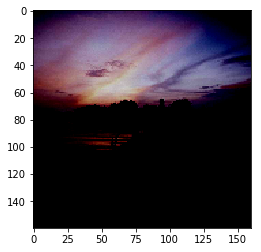

In [15]:
plt.imshow(pics[64]['pic']);

In [16]:
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [17]:
def extract_features(image_dict):
    """Return a vector of 1280 deep features for image."""
    image = image_dict['pic']
    image_np = image.numpy()
    images_np = np.expand_dims(image_np, axis=0)
    image_np.shape, images_np.shape
    deep_features = neural_network.predict(images_np)
    image_dict['deep_features'] = deep_features[0]
    return image_dict

In [ ]:
deep_features = list(map(extract_features, pics))

In [70]:
type(deep_features)

list

In [19]:
shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [27]:
train[0]

{'pic': <tf.Tensor: id=82998, shape=(160, 160, 3), dtype=float32, numpy=
 array([[[ 0.5862745 ,  0.5392157 ,  0.4294118 ],
         [ 0.57843137,  0.53137255,  0.42156866],
         [ 0.5431373 ,  0.49607846,  0.38627455],
         ...,
         [-0.04705882,  0.02156867, -0.50392157],
         [-0.03137255,  0.04901966, -0.50784314],
         [ 0.00784318,  0.082353  , -0.41960782]],
 
        [[ 0.48235297,  0.43137258,  0.3058824 ],
         [ 0.43529415,  0.38431376,  0.25882357],
         [ 0.454902  ,  0.4039216 ,  0.27843142],
         ...,
         [ 0.25098044,  0.30980396, -0.08039215],
         [ 0.29019612,  0.36470592, -0.05490196],
         [ 0.13921574,  0.22549024, -0.15882352]],
 
        [[ 0.34901965,  0.2941177 ,  0.16078436],
         [ 0.29019612,  0.23529416,  0.10196084],
         [ 0.29019612,  0.23529416,  0.10196084],
         ...,
         [ 0.3803922 ,  0.3686275 ,  0.08627456],
         [ 0.4529412 ,  0.49607846,  0.19019613],
         [ 0.3803922 ,  0.443

In [20]:
train[0].keys()

dict_keys(['pic', 'hashtag', 'name', 'deep_features'])

In [21]:
pic = train[0]

W0621 10:08:49.793334 4493796800 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


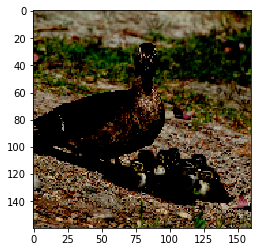

In [22]:
plt.imshow(pic['pic']);

In [23]:
pic['hashtag']

'babies'

In [24]:
pic['deep_features'].shape

(1280,)

In [25]:
pic['pic'].shape

TensorShape([160, 160, 3])

In [74]:
df = pd.DataFrame(deep_features)

In [ ]:
df.head()

In [76]:
df.to_csv('deep_features.csv')

## ALS Model

In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel

In [38]:
spark = SparkSession.builder.master('local').getOrCreate()

In [79]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_list, test_size=0.2)

In [81]:
train.head()

,hashtags,image,image_local_name,post_link,search_hashtag,clean_hashtags
558,[],https://scontent-sea1-1.cdninstagram.com/vp/42...,ea922ae5-1e2c-4e9e-aaea-2308927960d1.jpg,https://www.instagram.com/p/By4Aut_Ap0X/,selfie,[]
107,"[#son, #az, #paradigm, #affiliate, #fitness, #...",https://scontent-lga3-1.cdninstagram.com/vp/cc...,00d773ed-4628-418c-9927-31330067b2a8.jpg,https://www.instagram.com/p/By5jlVPnMh2/,fitness,"[#son, #az, #paradigm, #affiliate, #fitness, #..."
1528,"[#JDM, #fastandfurious, #Han, #automechanic, #...",https://scontent-lga3-1.cdninstagram.com/vp/e6...,4844be8e-8117-4b18-bac4-baa0a8da1bc2.jpg,https://www.instagram.com/p/By50GzVAAAC/,cars,"[#JDM, #fastandfurious, #Han, #automechanic, #..."
777,"[#thoreau, #fog, #travel, #lake, #photography,...",https://scontent-lga3-1.cdninstagram.com/vp/3c...,876b3ae9-e8b5-48eb-85d0-7902f07d0db4.jpg,https://www.instagram.com/p/By263uUgmJZ/,travel,"[#thoreau, #fog, #travel, #lake, #photography,..."
1787,"[#bmwfanatics, #low, #austria, #carphotography...",https://scontent-lga3-1.cdninstagram.com/vp/8a...,a2668d9e-fed6-47e0-90d7-0a78361682a9.jpg,https://www.instagram.com/p/By5zaqkIHMZ/,cars,"[#bmwfanatics, #low, #austria, #carphotography..."


In [83]:
len(train)

2400

In [85]:
#full_list.head()

In [42]:
full_list['clean_hashtags'] = full_list['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

In [43]:
image_lookup = dict(zip(full_list['image_local_name'], full_list.index))

In [44]:
all_hashtags = set()
for tags in full_list['clean_hashtags']:
    all_hashtags.update(tags)
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [45]:
hashtag_data = []
for i in full_list.index:
    hashtags = full_list.loc[i, 'clean_hashtags']
    for hashtag in hashtags:
        hashtag_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_df_long = pd.DataFrame(hashtag_data)

In [46]:
hashtag_df_long.tail()

,hashtag_id,image_id,rating
36041,5071,2699,1
36042,658,2699,1
36043,10699,2699,1
36044,10823,2699,1
36045,486,2699,1


In [47]:
full_list.dtypes

hashtags            object
image               object
image_local_name    object
post_link           object
search_hashtag      object
clean_hashtags      object
dtype: object

In [48]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

In [49]:
hashtag_spark_df = spark.createDataFrame(hashtag_df_long)

In [ ]:
als_model = als.fit(hashtag_spark_df)

In [68]:
als_model.save('als')

In [50]:
#load the model
#ALSModel model = ALSModel.load(“/path/to/read/the/model/from”)

In [ ]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()

In [77]:
len(recs)

1658

In [52]:
hashtag_index = list(all_hashtags)

In [53]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

In [54]:
def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [55]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [56]:
recs.index = recs['image_id']

In [57]:
compare_recs = recs.join(full_list, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [ ]:
compare_recs.loc[0, 'image_local_name']

In [87]:
compare_recs.to_pickle('recs.pkl')

In [58]:
compare_recs.drop('recommendations', axis=1)

,recommended_hashtags,hashtags,image_local_name,search_hashtag
image_id,,,,
1580,"[#jdm, #car, #cars, #carporn, #carlifestyle, #...","[#gt, #toyota, #ej, #r, #wrx, #impreza, #bmw, ...",98b75f05-52d5-460d-9580-f95f0f86f353.jpg,cars
1591,"[#cars, #car, #auto, #bmw, #audi, #toyota, #me...","[#bpautomobilemachtsm, #bpautomobile, #weilwir...",ba04590d-a8f1-495b-aa9e-b3cc575048fc.jpg,cars
463,"[#follow, #like, #selfie, #instagood, #food, #...","[#instagood, #instadaily, #koreanfood, #selca,...",e4ec8a33-df23-4d5e-b8b0-52168ba37a06.jpg,selfie
833,"[#art, #foodie, #architecture, #summer, #photo...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel
1645,"[#cars, #car, #auto, #bmw, #toyota, #jdm, #mer...","[#toyota, #minicarros, #vendas, #vendasonline,...",3cd627fc-a80d-4ed0-86c9-33f5c80f562d.jpg,cars
1829,"[#food, #foodie, #instafood, #foodporn, #yummy...","[#bhcidadecriativadagastronomia, #prato, #come...",56018a9a-8def-48d1-9a7d-03136314b0d9.jpg,food
1959,"[#foodporn, #foodie, #instafood, #foodstagram,...","[#hagerstownmd, #washingtoncountymd, #hswhmdbu...",2b98b605-8df1-4fcb-addf-887751caaaaa.jpg,food
2659,"[#pets, #animals, #animal, #pet, #dogstagram, ...","[#sportdogminsk, #dogminsk, #labrador, #labrad...",c62f34b0-da93-485c-94a0-d56be4b72018.jpg,animals
540,"[#selfie, #ootd, #daily, #selca, #repost, #ins...","[#tomboy, #hotel, #photobook, #selfie, #mirror]",f4963853-1824-4c44-a6d5-4f8059eb4c56.jpg,selfie


In [59]:
image_factors = als_model.userFactors.toPandas()

In [60]:
image_factors.index = image_factors['id']

In [61]:
compare_recs.join(image_factors)

,recommendations,recommended_hashtags,hashtags,image_local_name,search_hashtag,id,features
image_id,,,,,,,
1580,"[(11307, 1.089327335357666), (2452, 1.07650852...","[#jdm, #car, #cars, #carporn, #carlifestyle, #...","[#gt, #toyota, #ej, #r, #wrx, #impreza, #bmw, ...",98b75f05-52d5-460d-9580-f95f0f86f353.jpg,cars,1580,"[0.1485338807106018, 0.31975698471069336, -0.9..."
1591,"[(3212, 0.7940346598625183), (2452, 0.66501080...","[#cars, #car, #auto, #bmw, #audi, #toyota, #me...","[#bpautomobilemachtsm, #bpautomobile, #weilwir...",ba04590d-a8f1-495b-aa9e-b3cc575048fc.jpg,cars,1591,"[0.07799620181322098, 0.19556987285614014, -0...."
463,"[(4811, 0.959574818611145), (8661, 0.927076160...","[#follow, #like, #selfie, #instagood, #food, #...","[#instagood, #instadaily, #koreanfood, #selca,...",e4ec8a33-df23-4d5e-b8b0-52168ba37a06.jpg,selfie,463,"[0.3130095601081848, -0.1325574517250061, 0.19..."
833,"[(2304, 0.918540358543396), (6029, 0.788918375...","[#art, #foodie, #architecture, #summer, #photo...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel,833,"[-0.334102600812912, 0.3247702717781067, -0.35..."
1645,"[(3212, 0.719140350818634), (2452, 0.540755271...","[#cars, #car, #auto, #bmw, #toyota, #jdm, #mer...","[#toyota, #minicarros, #vendas, #vendasonline,...",3cd627fc-a80d-4ed0-86c9-33f5c80f562d.jpg,cars,1645,"[0.09052453190088272, 0.21956376731395721, -0...."
1829,"[(4068, 0.7660794258117676), (6029, 0.61289584...","[#food, #foodie, #instafood, #foodporn, #yummy...","[#bhcidadecriativadagastronomia, #prato, #come...",56018a9a-8def-48d1-9a7d-03136314b0d9.jpg,food,1829,"[-0.10602129250764847, 0.004272814840078354, -..."
1959,"[(745, 1.0295597314834595), (6029, 1.029177784...","[#foodporn, #foodie, #instafood, #foodstagram,...","[#hagerstownmd, #washingtoncountymd, #hswhmdbu...",2b98b605-8df1-4fcb-addf-887751caaaaa.jpg,food,1959,"[-0.2808643877506256, 0.5266156792640686, -0.0..."
2659,"[(2771, 0.8910551071166992), (7418, 0.86865395...","[#pets, #animals, #animal, #pet, #dogstagram, ...","[#sportdogminsk, #dogminsk, #labrador, #labrad...",c62f34b0-da93-485c-94a0-d56be4b72018.jpg,animals,2659,"[0.02834787406027317, -0.5530852675437927, -0...."
540,"[(10993, 0.6358941197395325), (3756, 0.5160882...","[#selfie, #ootd, #daily, #selca, #repost, #ins...","[#tomboy, #hotel, #photobook, #selfie, #mirror]",f4963853-1824-4c44-a6d5-4f8059eb4c56.jpg,selfie,540,"[0.27256396412849426, -0.07287263125181198, 0...."
